In [ ]:
!pip install opencv-contrib-python

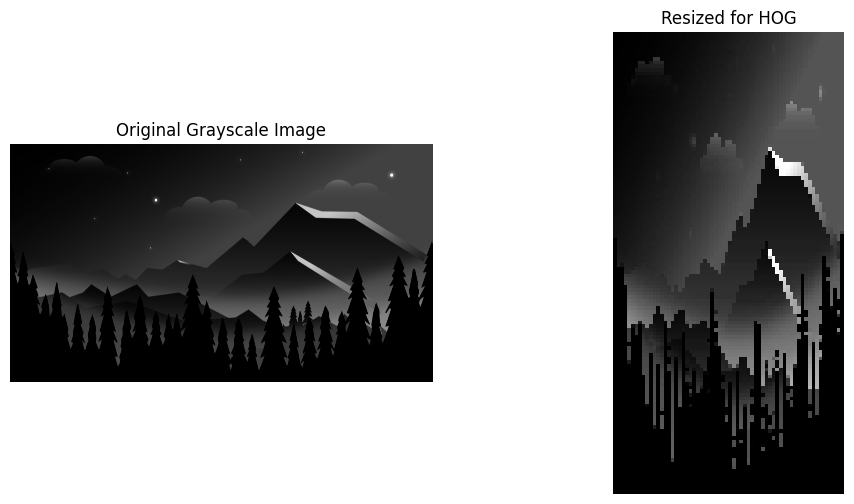

HOG Features (First 10 values): [0.08868125 0.14489824 0.0764832  0.01214797 0.16526932 0.02965472
 0.03299795 0.06248427 0.04279844 0.18831742]


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_dog
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle

# Load Image
image_path = "/content/4743565.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert to Grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# --- BLOB DETECTION ---
# 1. Laplacian of Gaussian (LoG)
log_blobs = blob_log(gray_image, min_sigma=1, max_sigma=30, num_sigma=10, threshold=0.05)

# 2. Difference of Gaussian (DoG)
dog_blobs = blob_dog(gray_image, min_sigma=1, max_sigma=30, threshold=0.05)

# --- HOG (Fixed Input Size) ---
win_size = (64, 128)
gray_resized = cv2.resize(gray_image, win_size)

block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
bins = 9

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, bins)
features = hog.compute(gray_resized)

# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(gray_image, cmap="gray")
ax[0].set_title("Original Grayscale Image")
ax[0].axis("off")

ax[1].imshow(gray_resized, cmap="gray")
ax[1].set_title("Resized for HOG")
ax[1].axis("off")

plt.show()

# Print extracted HOG features (first 10 values)
print("HOG Features (First 10 values):", features.flatten()[:10])

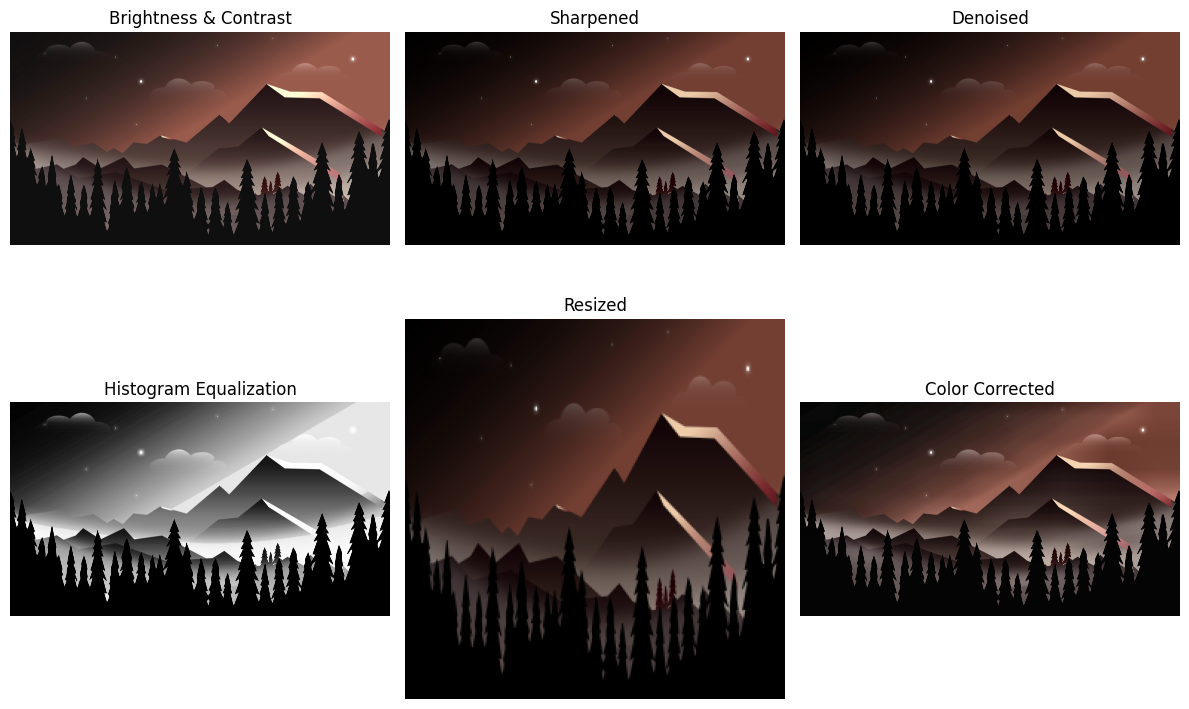

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Adjust Brightness & Contrast (Fixed Overexposure) ---
alpha = 1.2  # Contrast control (1.0-1.5 is recommended)
beta = 15    # Brightness control (-50 to 50)
brightness_contrast = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# --- 2. Sharpening ---
sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, sharpen_kernel)

# --- 3. Denoising (Balanced to Avoid Blur) ---
denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# --- 4. Histogram Equalization (Only for Grayscale) ---
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hist_eq = cv2.equalizeHist(gray)

# --- 5. Resizing the Image ---
resized = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)

# --- 6. Color Correction using CLAHE (Better than Direct Histogram Equalization) ---
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l = clahe.apply(l)
lab = cv2.merge((l, a, b))
color_corrected = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# --- Display Results ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Reduced to 6 subplots
ax = axes.ravel()

titles = ["Brightness & Contrast", "Sharpened", "Denoised",
          "Histogram Equalization", "Resized", "Color Corrected"]
images = [brightness_contrast, sharpened, denoised,
          hist_eq, resized, color_corrected]

for i in range(len(images)):
    ax[i].imshow(images[i], cmap='gray' if i == 3 else None)
    ax[i].set_title(titles[i])
    ax[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001
num_classes = 100

# Data augmentation and normalization for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

# Load CIFAR-100 datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to load and modify the pre-trained ResNet model
def get_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    else:
        raise ValueError("Model not supported!")
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Training function
def train_model(model, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

# Initialize models
models_to_train = {
    'ResNet18': get_model('resnet18'),
    'ResNet34': get_model('resnet34')
}

results = {}
for model_name, model in models_to_train.items():
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    print(f"Training {model_name} 😊")
    for epoch in range(num_epochs):
        train_loss = train_model(model, optimizer, criterion)
        test_loss, accuracy = evaluate_model(model, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    results[model_name] = accuracy

print("Final Results:", results)


100%|██████████| 169M/169M [00:12<00:00, 13.0MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weig

Training ResNet18 😊
Epoch [1/10] ResNet18 - Train Loss: 2.9968, Test Loss: 2.3778, Accuracy: 37.96%
Epoch [2/10] ResNet18 - Train Loss: 2.2723, Test Loss: 2.1766, Accuracy: 42.32%
Epoch [3/10] ResNet18 - Train Loss: 2.0316, Test Loss: 1.9890, Accuracy: 46.55%
Epoch [4/10] ResNet18 - Train Loss: 1.8805, Test Loss: 1.8943, Accuracy: 49.52%
Epoch [5/10] ResNet18 - Train Loss: 1.7504, Test Loss: 1.8968, Accuracy: 49.36%
Epoch [6/10] ResNet18 - Train Loss: 1.6501, Test Loss: 1.7883, Accuracy: 51.53%
Epoch [7/10] ResNet18 - Train Loss: 1.5628, Test Loss: 1.7607, Accuracy: 53.33%
Epoch [8/10] ResNet18 - Train Loss: 1.4988, Test Loss: 1.7345, Accuracy: 53.35%
Epoch [9/10] ResNet18 - Train Loss: 1.4246, Test Loss: 1.6769, Accuracy: 55.26%
Epoch [10/10] ResNet18 - Train Loss: 1.3684, Test Loss: 1.6742, Accuracy: 54.67%
Training ResNet34 😊
Epoch [1/10] ResNet34 - Train Loss: 3.0853, Test Loss: 2.6693, Accuracy: 30.81%
Epoch [2/10] ResNet34 - Train Loss: 2.4359, Test Loss: 2.4248, Accuracy: 41.18%

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Set device and random seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# MNIST dataset transformation and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define a simple CNN to extract embeddings from images
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, 5),  # (28-5+1)=24
            nn.ReLU(),
            nn.MaxPool2d(2),      # 24/2=12
            nn.Conv2d(32, 64, 5), # (12-5+1)=8
            nn.ReLU(),
            nn.MaxPool2d(2)       # 8/2=4
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 256),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Compute class prototypes (mean embedding per class)
def compute_prototypes(embeddings, targets, num_classes):
    prototypes = []
    for cls in range(num_classes):
        cls_indices = (targets == cls).nonzero().squeeze()
        cls_embeddings = embeddings[cls_indices]
        prototype = cls_embeddings.mean(0)
        prototypes.append(prototype)
    return torch.stack(prototypes)

# Episodic training for few-shot learning using a prototypical network
def episodic_training(embedding_net, optimizer, num_episodes=100, num_classes=5, k_shot=5, q_query=10):
    embedding_net.train()
    loss_fn = nn.CrossEntropyLoss()
    for episode in range(num_episodes):
        # Randomly select 'num_classes' classes for this episode
        classes = np.random.choice(np.unique(mnist_train.targets.numpy()), num_classes, replace=False)
        support_images, support_labels = [], []
        query_images, query_labels = [], []

        # For each class, select k_shot support examples and q_query query examples
        for idx, cls in enumerate(classes):
            cls_indices = np.where(mnist_train.targets.numpy() == cls)[0]
            selected = np.random.choice(cls_indices, k_shot + q_query, replace=False)
            support_idx = selected[:k_shot]
            query_idx = selected[k_shot:]
            for i in support_idx:
                img, _ = mnist_train[i]
                support_images.append(img)
                support_labels.append(idx)
            for i in query_idx:
                img, _ = mnist_train[i]
                query_images.append(img)
                query_labels.append(idx)

        support_images = torch.stack(support_images).to(device)
        support_labels = torch.tensor(support_labels).to(device)
        query_images = torch.stack(query_images).to(device)
        query_labels = torch.tensor(query_labels).to(device)

        optimizer.zero_grad()
        support_embeddings = embedding_net(support_images)
        query_embeddings = embedding_net(query_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, num_classes)

        # Calculate Euclidean distances between query embeddings and prototypes
        dists = torch.cdist(query_embeddings, prototypes)
        logits = -dists  # lower distance means higher similarity
        loss = loss_fn(logits, query_labels)
        loss.backward()
        optimizer.step()

        if (episode+1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f} 😊")

# Initialize model and optimizer
embedding_net = EmbeddingNet().to(device)
optimizer = optim.Adam(embedding_net.parameters(), lr=0.001)

print("Starting Episodic Training for Prototypical Network 😊")
episodic_training(embedding_net, optimizer)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]


Starting Episodic Training for Prototypical Network 😊
Episode 10/100, Loss: 0.1797 😊
Episode 20/100, Loss: 0.3746 😊
Episode 30/100, Loss: 0.2884 😊
Episode 40/100, Loss: 0.1811 😊
Episode 50/100, Loss: 0.0666 😊
Episode 60/100, Loss: 0.0588 😊
Episode 70/100, Loss: 0.0521 😊
Episode 80/100, Loss: 0.0264 😊
Episode 90/100, Loss: 0.0938 😊
Episode 100/100, Loss: 0.0511 😊


Training ResNet18 😊
Epoch [1/10] ResNet18 - Train Loss: 2.9571, Test Loss: 2.3528, Accuracy: 38.30% 😊
Epoch [2/10] ResNet18 - Train Loss: 2.2450, Test Loss: 2.1769, Accuracy: 41.93% 😊
Epoch [3/10] ResNet18 - Train Loss: 2.0201, Test Loss: 1.9600, Accuracy: 47.45% 😊
Epoch [4/10] ResNet18 - Train Loss: 1.8503, Test Loss: 1.8912, Accuracy: 48.69% 😊
Epoch [5/10] ResNet18 - Train Loss: 1.7348, Test Loss: 1.9024, Accuracy: 50.08% 😊
Epoch [6/10] ResNet18 - Train Loss: 1.6415, Test Loss: 1.8734, Accuracy: 51.01% 😊
Epoch [7/10] ResNet18 - Train Loss: 1.5567, Test Loss: 1.7415, Accuracy: 52.99% 😊
Epoch [8/10] ResNet18 - Train Loss: 1.4720, Test Loss: 1.7638, Accuracy: 52.35% 😊
Epoch [9/10] ResNet18 - Train Loss: 1.4213, Test Loss: 1.6943, Accuracy: 54.69% 😊
Epoch [10/10] ResNet18 - Train Loss: 1.4202, Test Loss: 1.6956, Accuracy: 54.25% 😊
Training ResNet34 😊
Epoch [1/10] ResNet34 - Train Loss: 3.1177, Test Loss: 3.1756, Accuracy: 30.83% 😊
Epoch [2/10] ResNet34 - Train Loss: 2.3028, Test Loss: 2.

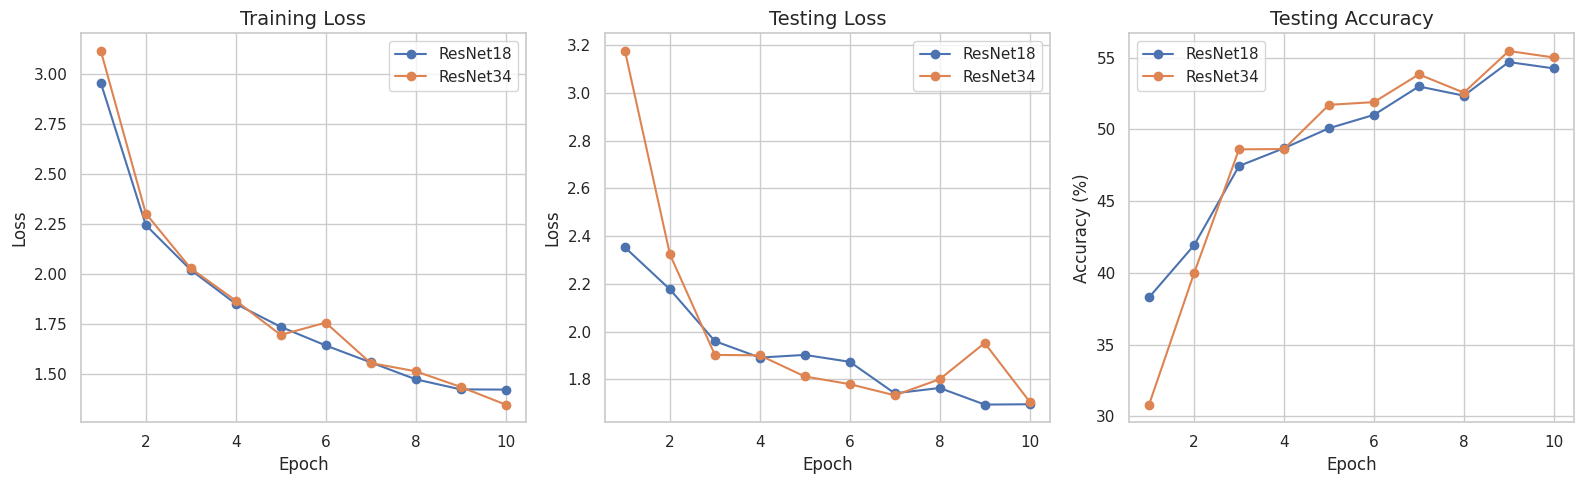


Final Evaluation Metrics:
      Model  Final Accuracy (%)
0  ResNet18               54.25
1  ResNet34               55.01


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style for better visuals
sns.set(style="whitegrid")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001
num_classes = 100

# Data augmentation and normalization for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

# Load CIFAR-100 datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to load and modify the pre-trained ResNet model
def get_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    else:
        raise ValueError("Model not supported!")
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Training function that saves metrics
def train_model(model, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

# Evaluation function that saves metrics
def evaluate_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

# Initialize models and prepare to store metrics
models_to_train = {
    'ResNet18': get_model('resnet18'),
    'ResNet34': get_model('resnet34')
}

results = {}
history = {}  # To store training and testing metrics for each model

for model_name, model in models_to_train.items():
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    history[model_name] = {'train_loss': [], 'test_loss': [], 'accuracy': []}
    print(f"Training {model_name} 😊")
    for epoch in range(num_epochs):
        train_loss = train_model(model, optimizer, criterion)
        test_loss, accuracy = evaluate_model(model, criterion)
        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['test_loss'].append(test_loss)
        history[model_name]['accuracy'].append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}% 😊")
    results[model_name] = accuracy

# Visualization: Plotting the training curves and accuracy for each model
epochs = range(1, num_epochs+1)
plt.figure(figsize=(16, 5))

# Plot training loss
plt.subplot(1, 3, 1)
for model_name in history:
    plt.plot(epochs, history[model_name]['train_loss'], marker='o', label=model_name)
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot test loss
plt.subplot(1, 3, 2)
for model_name in history:
    plt.plot(epochs, history[model_name]['test_loss'], marker='o', label=model_name)
plt.title('Testing Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 3, 3)
for model_name in history:
    plt.plot(epochs, history[model_name]['accuracy'], marker='o', label=model_name)
plt.title('Testing Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optionally, print final results in a tabular format
import pandas as pd
df_results = pd.DataFrame({
    'Model': list(results.keys()),
    'Final Accuracy (%)': list(results.values())
})
print("\nFinal Evaluation Metrics:")
print(df_results)
